In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
from os import getcwd, path as path_lib
import math

log_path = path_lib.join(getcwd(), "ConSteer")
scene_path = path_lib.join(getcwd().split("\\")[0].upper()+"\\",*getcwd().split("\\")[1:-1],"Project-Code","Scenarios","All_2Cop.csv")
# for scene_path use scene.csv not scene_swarm_position.csv file path
# for log_path link to drone log file directory that matches with the scene

In [2]:
drone_ids = [*range(50,52)]
files = glob(path_lib.join(log_path,"*.log"))

len(files) == len(drone_ids)

True

In [3]:
drone_protocol = dict()

for d_id,file_path in zip(drone_ids,files):
    drone_protocol[d_id] = dict()
    with open(file_path,"r") as file:
        lines = file.readlines()
        for line in lines[1:-1]:
            key = float(line.split("]")[0].strip("[").strip())
            pos = [float(coord.strip()) for coord in line.split("pos:")[-1].split("/")[0].split(",")]
            drone_protocol[d_id][key] = pos

print(drone_protocol.keys())
for key in drone_protocol.keys():
    print("-> protocol from drone "+str(key)+": ")
    print("   first_timestamp:",list(drone_protocol[key].keys())[0])
    print("   first_pos:",drone_protocol[key][list(drone_protocol[key].keys())[0]])
    print("   timestamp_amount:",len(drone_protocol[key].keys()))


dict_keys([50, 51])
-> protocol from drone 50: 
   first_timestamp: 0.02931
   first_pos: [52.13591652, 11.64344738]
   timestamp_amount: 317
-> protocol from drone 51: 
   first_timestamp: 0.02931
   first_pos: [52.13741233, 11.64344738]
   timestamp_amount: 317


In [4]:
scene = dict()

with open(scene_path, "r") as file:
    lines = file.readlines()
    for line in lines[2:]:
        vals = [val.strip() for val in line.split(",")]
        scene[vals[-1]] = scene.get(vals[-1], [])
        scene[vals[-1]].append([round(float(vals[0]),8),round(float(vals[1]),8)])

print(scene.keys())
for key in scene.keys():
    print("-> "+str(key)+"s in scene: ")
    print("   first_"+str(key)+":",scene[key][0])
    print("   "+str(key)+"_amount:",len(scene[key]))

dict_keys(['att', 'rep', 'spawn'])
-> atts in scene: 
   first_att: [52.13716576, 11.64242715]
   att_amount: 1
-> reps in scene: 
   first_rep: [52.13741576, 11.64354715]
   rep_amount: 3
-> spawns in scene: 
   first_spawn: [52.13591576, 11.64344715]
   spawn_amount: 2


In [5]:
# gets the metric distance between two points given in the LlaCoor_f format
def getDistance(own_pos_lat, own_pos_lon, goal_pos_lat, goal_pos_lon)->float:
    # GLOBE_RADIUS:int = int(6371000)
    own_pos_lat *= math.pi/180
    own_pos_lon *= math.pi/180
    goal_pos_lat *= math.pi/180
    goal_pos_lon *= math.pi/180
    return float( 6371000 * math.acos(                  
        math.sin(own_pos_lat) * math.sin(goal_pos_lat) +    
        math.cos(own_pos_lat) * math.cos(goal_pos_lat) *    
        math.cos(own_pos_lon - goal_pos_lon)
    ))

GOAL Achievement Analysis

In [6]:
reached = {}
last_goal_time = 0
last_drone_pos = [drone_protocol[d_id][list(drone_protocol[d_id].keys())[0]] for d_id in drone_protocol.keys()]
for timestamp in drone_protocol[list(drone_protocol.keys())[0]].keys():
    for d_id in drone_protocol.keys():
        for att_id, att in enumerate(scene["att"]):
            if getDistance(*drone_protocol[d_id][timestamp],*att) < 1.5 \
            and not reached.get(str(d_id)+"->"+str(att_id), None):
                reached[str(d_id)+"->"+str(att_id)] = [getDistance(*last_drone_pos[drone_ids.index(d_id)],*att),timestamp-last_goal_time]
                last_drone_pos = [*[drone_protocol[d_id][timestamp] for d_id in drone_protocol.keys()]]

for key in reached.keys():
    print("Drone",key.split("->")[0],"reached ATT_Point",key.split("->")[1],"approximately after",
    str(reached[key][1])+"sec and {:.8f}m of travel.".format(reached[key][0]))

Drone 51 reached ATT_Point 0 approximately after 103.270851sec and 74.83250398m of travel.


DANGER Avoidance Analysis

In [7]:
min_dist = {}
for timestamp in drone_protocol[list(drone_protocol.keys())[0]].keys():
    for d_id in drone_protocol.keys():
        for rep_id, rep in enumerate(scene["rep"]):
            dist = getDistance(*drone_protocol[d_id][timestamp],*rep)
            if not min_dist.get(str(d_id)+"<->"+str(rep_id), None) \
            or dist < min_dist[str(d_id)+"<->"+str(rep_id)][1]:
                min_dist[str(d_id)+"<->"+str(rep_id)] = [timestamp, dist]

for key in min_dist.keys():
    print("Smallest distance between Drone",key.split("<->")[0],"and REP_Point",key.split("<->")[1],
    "was {0:.8f}m and occured".format(round(min_dist[key][1],8)),
    "{0:.6f}sec after simulation start.".format(min_dist[key][0]))

Smallest distance between Drone 50 and REP_Point 0 was 85.05794763m and occured 90.913757sec after simulation start.
Smallest distance between Drone 50 and REP_Point 1 was 75.68278632m and occured 93.704071sec after simulation start.
Smallest distance between Drone 50 and REP_Point 2 was 72.34916847m and occured 89.717911sec after simulation start.
Smallest distance between Drone 51 and REP_Point 0 was 6.76109970m and occured 28.729662sec after simulation start.
Smallest distance between Drone 51 and REP_Point 1 was 6.78239456m and occured 29.128279sec after simulation start.
Smallest distance between Drone 51 and REP_Point 2 was 5.26184830m and occured 36.701981sec after simulation start.


Swarming Analysis

In [8]:
entropy = list()
timestamps = list()
for timestamp in drone_protocol[list(drone_protocol.keys())[0]].keys():
    drone_pos = np.array([drone_protocol[d_id][timestamp] for d_id in drone_protocol.keys()])
    centeroid = np.average(drone_pos,axis=0)
    dist = np.linalg.norm(drone_pos - centeroid, axis=1)
    probs = dist/np.sum(dist)
    entropy.append(-np.sum(probs*np.log2(probs)))
    timestamps.append(timestamp)
print("Average Entropy: {:.4f} - std: {:.4f}".format(np.average(entropy),np.std(entropy)))


Average Entropy: 1.0000 - std: 0.0000


In [9]:
dr_min_dist = list()
drone_pairs = list()
for timestamp in drone_protocol[list(drone_protocol.keys())[0]].keys():
    drone_pos = np.array([drone_protocol[d_id][timestamp] for d_id in drone_protocol.keys()])
    min_drone_dist = dict()
    for i,d_pos in enumerate(drone_pos):
        dists = dict()
        for j,o_pos in enumerate(drone_pos[i+1:]):
            dists[abs(getDistance(*d_pos,*o_pos))] = str(i)+"<->"+str(j+i+1)
        if dists: min_drone_dist[np.min(list(dists.keys()))] = dists[np.min(list(dists.keys()))]
    dr_min_dist.append(np.min(list(min_drone_dist.keys())))
    drone_pairs.append(min_drone_dist[dr_min_dist[-1]])

for key,dist,time in zip(drone_pairs[::75],dr_min_dist[::75],timestamps[::75]):
    print("Smallest distance between Drone",str(drone_ids[int(key.split("<->")[0])]),"and Drone",
    str(drone_ids[int(key.split("<->")[1])]),"was {0:.8f}m and occured".format(round(dist,8)),
    "{0:.6f}sec after simulation start.".format(time))

Smallest distance between Drone 50 and Drone 51 was 166.32647948m and occured 0.029310sec after simulation start.
Smallest distance between Drone 50 and Drone 51 was 165.56813949m and occured 29.925510sec after simulation start.
Smallest distance between Drone 50 and Drone 51 was 62.28131803m and occured 59.821709sec after simulation start.
Smallest distance between Drone 50 and Drone 51 was 25.37491054m and occured 89.717911sec after simulation start.
Smallest distance between Drone 50 and Drone 51 was 16.99103153m and occured 119.614113sec after simulation start.


Behaviour Evaluation

In [10]:
# Goal Stats
fastest_goal = min([tuplett[1]/tuplett[0] for tuplett in reached.values()])
slowest_goal = max([tuplett[1]/tuplett[0] for tuplett in reached.values()])
avg_goal = np.average([tuplett[1]/tuplett[0] for tuplett in reached.values()])
std_goal = np.std([tuplett[1]/tuplett[0] for tuplett in reached.values()])
percentiles_goal = np.percentile([tuplett[1]/tuplett[0] for tuplett in reached.values()],[25,50,75])

print("Goal Stats:\n-----------")
print("Shortest travel time to goal:           {:>5.2f} sec/m".format(round(fastest_goal,2)))
print("Average travel time to goal:            {:>5.2f} sec/m".format(round(avg_goal,2)))
print("Longest travel time to goal:            {:>5.2f} sec/m".format(round(slowest_goal,2)))
print("Standard Deviation in travel times:     {:>5.2f} sec/m".format(round(std_goal,2)))
print("First percentile(Q1) in travel times:   {:>5.2f} sec/m".format(round(percentiles_goal[0],2)))
print("Median(2nd percentile) in travel times: {:>5.2f} sec/m".format(round(percentiles_goal[1],2)))
print("Third percentile(Q3) in travel times:   {:>5.2f} sec/m".format(round(percentiles_goal[2],2)))

Goal Stats:
-----------
Shortest travel time to goal:            1.38 sec/m
Average travel time to goal:             1.38 sec/m
Longest travel time to goal:             1.38 sec/m
Standard Deviation in travel times:      0.00 sec/m
First percentile(Q1) in travel times:    1.38 sec/m
Median(2nd percentile) in travel times:  1.38 sec/m
Third percentile(Q3) in travel times:    1.38 sec/m


In [11]:
# Danger Stats
smallest_dist = min([tuplett[1] for tuplett in min_dist.values()])
furthest_dist = max([tuplett[1] for tuplett in min_dist.values()])
avg_dist = np.average([tuplett[1] for tuplett in min_dist.values()])
std_dist = np.std([tuplett[1] for tuplett in min_dist.values()])
percentiles_dist = np.percentile([tuplett[1] for tuplett in min_dist.values()],[25,50,75])

print("\nDanger Stats:\n-------------")
print("Smallest minimal distance to danger:         {:>6.2f} m".format(round(smallest_dist,2)))
print("Average minimal distance to danger:          {:>6.2f} m".format(round(avg_dist,2)))
print("Furthest minimal distance to danger:         {:>6.2f} m".format(round(furthest_dist,2)))
print("Standard Deviation in minimal distances:     {:>6.2f} m".format(round(std_dist,2)))
print("First percentile(Q1) in minimal distances:   {:>6.2f} m".format(round(percentiles_dist[0],2)))
print("Median(2nd percentile) in minimal distances: {:>6.2f} m".format(round(percentiles_dist[1],2)))
print("Third percentile(Q3) in minimal distances:   {:>6.2f} m".format(round(percentiles_dist[2],2)))


Danger Stats:
-------------
Smallest minimal distance to danger:           5.26 m
Average minimal distance to danger:           41.98 m
Furthest minimal distance to danger:          85.06 m
Standard Deviation in minimal distances:      35.92 m
First percentile(Q1) in minimal distances:     6.77 m
Median(2nd percentile) in minimal distances:  39.57 m
Third percentile(Q3) in minimal distances:    74.85 m


In [12]:
# Swarm Stats
smallest_entropy = min(entropy)
largest_entropy = max(entropy)
avg_entropy = np.average(entropy)
std_entropy = np.std(entropy)
percentiles_entropy = np.percentile(entropy,[25,50,75])

smallest_ddist = min(dr_min_dist)
furthest_ddist = max(dr_min_dist)
avg_ddist = np.average(dr_min_dist)
std_ddist = np.std(dr_min_dist)
percentiles_ddist = np.percentile(dr_min_dist,[25,50,75])

print("\nSwarm Stats:\n-------------")
print("Smallest entropy of swarm formation:         {:>6.4f}".format(round(smallest_entropy,4)))
print("Average entropy of swarm formation:          {:>6.4f}".format(round(avg_entropy,4)))
print("Largest entropy of swarm formation:          {:>6.4f}".format(round(largest_entropy,4)))
print("Standard Deviation in formation entropy:     {:>6.4f}".format(round(std_entropy,4)))
print("First percentile(Q1) in formation entropy:   {:>6.4f}".format(round(percentiles_entropy[0],4)))
print("Median(2nd percentile) in formation entropy: {:>6.4f}".format(round(percentiles_entropy[1],4)))
print("Third percentile(Q3) in formation entropy:   {:>6.4f}".format(round(percentiles_entropy[2],4)))
print("-----------------------------------------------------")
print("Smallest minimal distance to other drones:   {:>6.2f} m".format(round(smallest_ddist,2)))
print("Average minimal distance to other drones:    {:>6.2f} m".format(round(avg_ddist,2)))
print("Furthest minimal distance to other drones:   {:>6.2f} m".format(round(furthest_ddist,2)))
print("Standard Deviation in minimal distances:     {:>6.2f} m".format(round(std_ddist,2)))
print("First percentile(Q1) in minimal distances:   {:>6.2f} m".format(round(percentiles_ddist[0],2)))
print("Median(2nd percentile) in minimal distances: {:>6.2f} m".format(round(percentiles_ddist[1],2)))
print("Third percentile(Q3) in minimal distances:   {:>6.2f} m".format(round(percentiles_ddist[2],2)))


Swarm Stats:
-------------
Smallest entropy of swarm formation:         1.0000
Average entropy of swarm formation:          1.0000
Largest entropy of swarm formation:          1.0000
Standard Deviation in formation entropy:     0.0000
First percentile(Q1) in formation entropy:   1.0000
Median(2nd percentile) in formation entropy: 1.0000
Third percentile(Q3) in formation entropy:   1.0000
-----------------------------------------------------
Smallest minimal distance to other drones:    13.14 m
Average minimal distance to other drones:     80.76 m
Furthest minimal distance to other drones:   167.09 m
Standard Deviation in minimal distances:      62.46 m
First percentile(Q1) in minimal distances:    22.72 m
Median(2nd percentile) in minimal distances:  50.17 m
Third percentile(Q3) in minimal distances:   160.63 m


In [13]:
# Save Stats to file
result_file_path = path_lib.join(getcwd(), scene_path.split("\\")[-1].strip(".csv")+"_res.csv")
with open(result_file_path, "w") as results:
    results.write("{:.12f},{:.12f},{:.12f},{:.12f},{:.12f},{:.12f}\n".format(
        round(slowest_goal,12),round(avg_goal,12),round(fastest_goal,12),
        round(std_goal,12),round(percentiles_goal[0],12),
        round(percentiles_goal[1],12),round(percentiles_goal[2],12)))
    results.write("{:.12f},{:.12f},{:.12f},{:.12f},{:.12f},{:.12f}\n".format(
        round(smallest_dist,12),round(avg_dist,12),round(furthest_dist,12),
        round(std_dist,12),round(percentiles_dist[0],12),
        round(percentiles_dist[1],12),round(percentiles_dist[2],12)))
print("Saved Results to",result_file_path)

Saved Results to c:\Users\nilst\Projects\FINkenSim\sharedFolder\swarmBehaviours\Log-Files\All_2Cop_res.csv


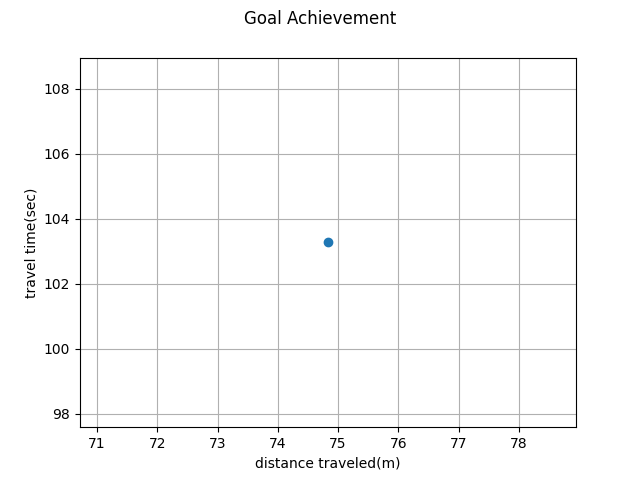

In [14]:
for it in range(2):
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    plt.grid()
    plt.scatter([tuplett[0] for tuplett in reached.values()],[tuplett[1] for tuplett in reached.values()])
    plt.suptitle('Goal Achievement')
    plt.ylabel("travel time(sec)")
    plt.xlabel("distance traveled(m)")
    if it==0: plt.show()
    else: 
        plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.98)
        plt.savefig("./plots/"+scene_path.split("\\")[-1].split(".")[0]+"_goal.png")
        plt.clf()
        plt.close();

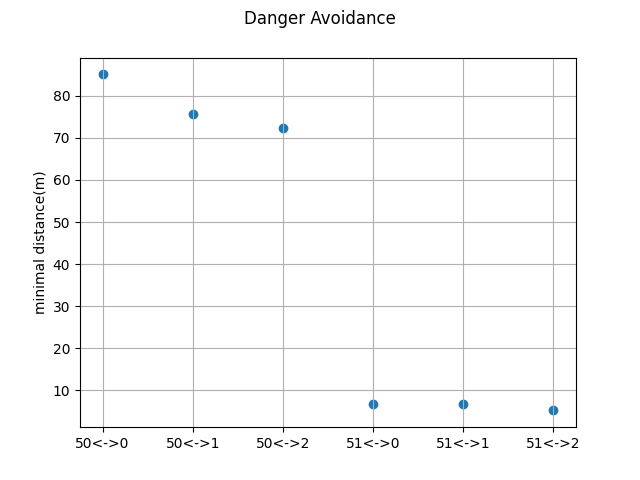

In [15]:
for it in range(2):
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    plt.grid()
    plt.scatter([*range(len(min_dist))],[tuplett[1] for tuplett in min_dist.values()])
    plt.suptitle('Danger Avoidance')
    plt.ylabel("minimal distance(m)")
    plt.xticks([*range(len(min_dist))],list(min_dist.keys()))
    if it==0: plt.show()
    else: 
        plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.98)
        plt.savefig("./plots/"+scene_path.split("\\")[-1].split(".")[0]+"_danger.png")
        plt.clf()
        plt.close();

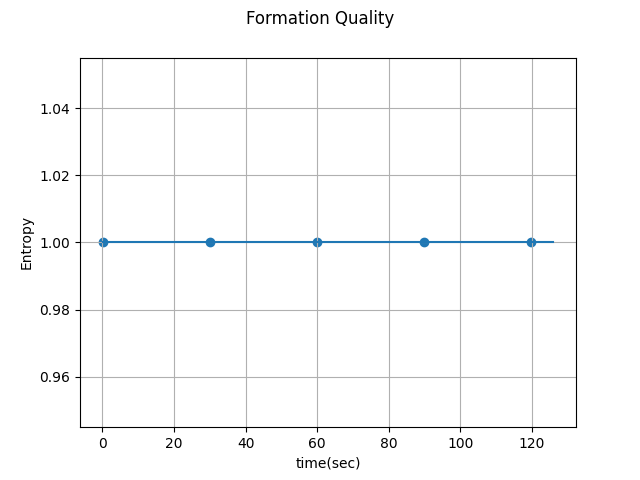

In [16]:
for it in range(2):
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    plt.grid()
    plt.plot(timestamps,entropy)
    plt.scatter(timestamps[::75],entropy[::75])
    plt.suptitle('Formation Quality')
    plt.ylabel("Entropy")
    plt.xlabel("time(sec)")
    if it==0: plt.show()
    else: 
        plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.98)
        plt.savefig("./plots/"+scene_path.split("\\")[-1].split(".")[0]+"_entropy.png")
        plt.clf()
        plt.close();

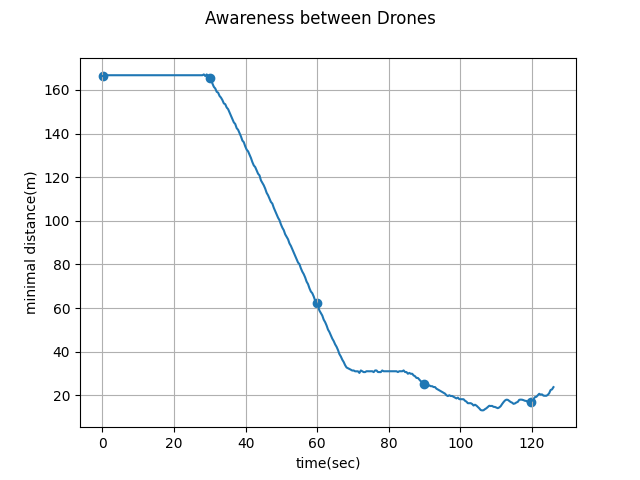

In [17]:
for it in range(2):
    if it==0: plt.figure()
    else: plt.figure(dpi=1200)
    plt.grid()
    plt.plot(timestamps,dr_min_dist)
    plt.scatter(timestamps[::75],dr_min_dist[::75])
    plt.suptitle('Awareness between Drones')
    plt.ylabel("minimal distance(m)")
    plt.xlabel("time(sec)")
    if it==0: plt.show()
    else: 
        plt.subplots_adjust(left=0.10,bottom=0.10,top=0.92,right=0.98)
        plt.savefig("./plots/"+scene_path.split("\\")[-1].split(".")[0]+"_drones.png")
        plt.clf()
        plt.close();